# EDA
- a little bit of EDA 
- how to cross-validate
- how to preprocess the data for various classifiers
- how to tune the most important hyperparameters of some models
- how an ensemble performs better than any single model
----
>>진행순서: <br>

EDA
- original data 사용하지 않음
- log-transformation
- corss validation(stratifiedKFold)

Models
- LinearSVC
- LogisticRegression
- kernel approximation for logistic regression
- ExtraTreesClassifier
- RandomForestClassifier
- KNeighborsClassifier
- HistGradientBoostingClasssifier

Ensemble
- HGB + RF + NY

AUC score explained

Submission

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier

np.set_printoptions(linewidth=195, edgeitems=5)


# Reading the data

In [3]:
result_list = []
train = pd.read_csv('/Users/ibeub/Desktop/data/train.csv', index_col='id')
test = pd.read_csv('/Users/ibeub/Desktop/data/test.csv', index_col='id')
original = pd.read_csv('/Users/ibeub/Desktop/data/jm1.csv',
                       na_values=['?'])
with pd.option_context("display.min_rows", 6):
    display(train)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101760,26.0,1.0,1.0,1.0,83.0,360.17,0.04,22.75,12.56,5893.69,...,20,0,4,0,10.0,8.0,51.0,28.0,1.0,False
101761,10.0,2.0,1.0,2.0,43.0,191.76,0.15,6.46,29.53,1534.04,...,7,0,1,0,11.0,14.0,24.0,19.0,3.0,False
101762,136.0,18.0,18.0,1.0,296.0,1704.57,0.02,44.82,44.08,77011.02,...,102,1,11,0,22.0,31.0,162.0,135.0,35.0,False


# EDA

How much of an EDA can we do here?

- `defects` is the target column, the 21 other columns are the features. All features are numerical.
- There are no missing values (print `train.isna().sum().sum()` to verify).
- There are no duplicates (print `train.duplicated().sum()` to verify).
- The dataset is somewhat unbalanced: Only 23 % of the samples belong to the positive class (i.e., have defect==True). Print `train.defects.mean()` to verify(). We'll use a `StratifiedKFold` for cross-validation. There is no need for upsampling, downsampling or similar voodoo.
- The dataset has \>100000 rows. For some algorithms (e.g., kernel methods or Neighborhood Components Analysis), this is too much.
- \>100000 rows with 21 features is abundant data. We don't need to worry much about overfitting.

이 경쟁에서는 다양한 색상의 도표가 포함된 화려한 EDA가 필요하지 않다. 몇 가지 머신러닝 모델을 조정하고 교차 검증함으로써 데이터에 대해 훨씬 더 많은 것을 배울 수 있다.

그러나 언급할 만한 두 가지 포인트가 있다:

1. 원래 데이터와 합성 데이터 사이에는 큰 차이가 있다. 훈련에 원래 데이터를 포함시키지 않을 것을 추천한다.
2. 모든 21개의 특징들은 음수가 아니며 그들의 분포는 오른쪽으로 치우쳐 있어, 지수 분포를 닮아서 로그변환 추천한다.

## Differences between original and synthetic data
이 대회의 'train'과 'test'는 현실 세계 데이터넷 'original'을 기반으로 생성된 합성 데이터로 구성되어 있음. 그러나 분포는 동일하지 않음.

[original dataset]의 설명에 따르면 데이터셋의 아홉 개 열은 "유도된 측정값"임:
- P = volume = V = N * log2(mu) (the number of mental comparisons needed to write a program of length N)
- V* = volume on minimal implementation = (2 + mu2')*log2(2 + mu2')
- L  = program length = V*/N
- D  = difficulty = 1/L
- L' = 1/D 
- I  = intelligence = L'*V'
- E  = effort to write program = V/L 
- T  = time to write program = E/18 seconds

다음과 같이 두 개의 예시(도표 형태)로 합성 데이터에 대해 이러한 관계가 유지되지 않으며, 데이터셋 간의 결함 비율도 다르다는 것을 보여줌

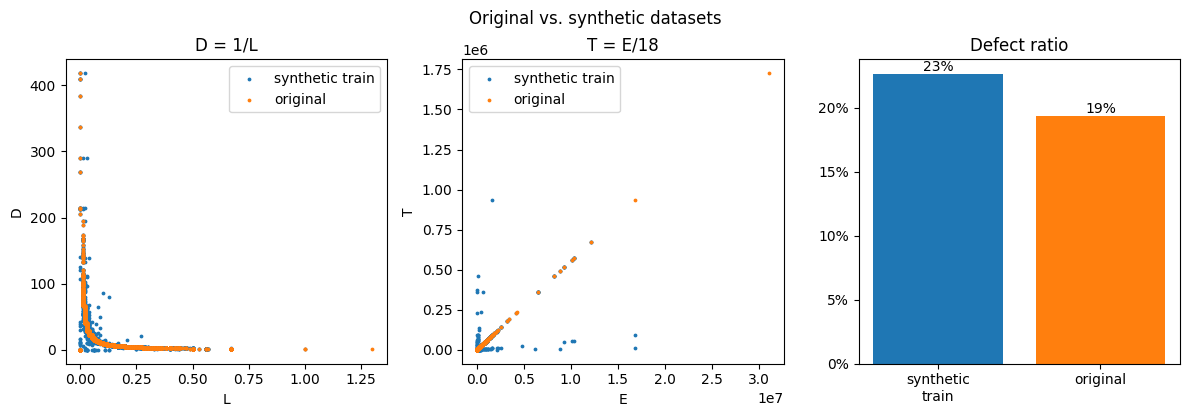

In [4]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.scatter(train.l, train.d, s=3, label='synthetic train')
ax1.scatter(original.l, original.d, s=3, label='original')
ax1.set_xlabel('L')
ax1.set_ylabel('D')
ax1.set_title('D = 1/L')
ax1.legend()
ax2.scatter(train.e, train.t, s=3, label='synthetic train')
ax2.scatter(original.e, original.t, s=3, label='original')
ax2.set_xlabel('E')
ax2.set_ylabel('T')
ax2.set_title('T = E/18')
ax2.legend()
bars1 = ax3.bar([0], [train.defects.mean()*100])
bars2 = ax3.bar([1], [original.defects.mean()*100])
ax3.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
ax3.bar_label(bars1, fmt='{:.0f}%')
ax3.bar_label(bars2, fmt='{:.0f}%')
ax3.set_xticks([0, 1], ['synthetic\ntrain', 'original'])
ax3.set_title('Defect ratio')
plt.tight_layout()
plt.suptitle('Original vs. synthetic datasets', y=1.03)
plt.show()

**Insight:** 이러한 차이점을 고려할 때, 모델 훈련에 원래 데이터셋을 사용하지 않는 것을 추천함.

## A log-transformation is recommended

모든 21개의 특징들은 음수가 아니며 그들의 히스토그램은 오른쪽으로 치우쳐 있어, 지수 분포를 닮음.

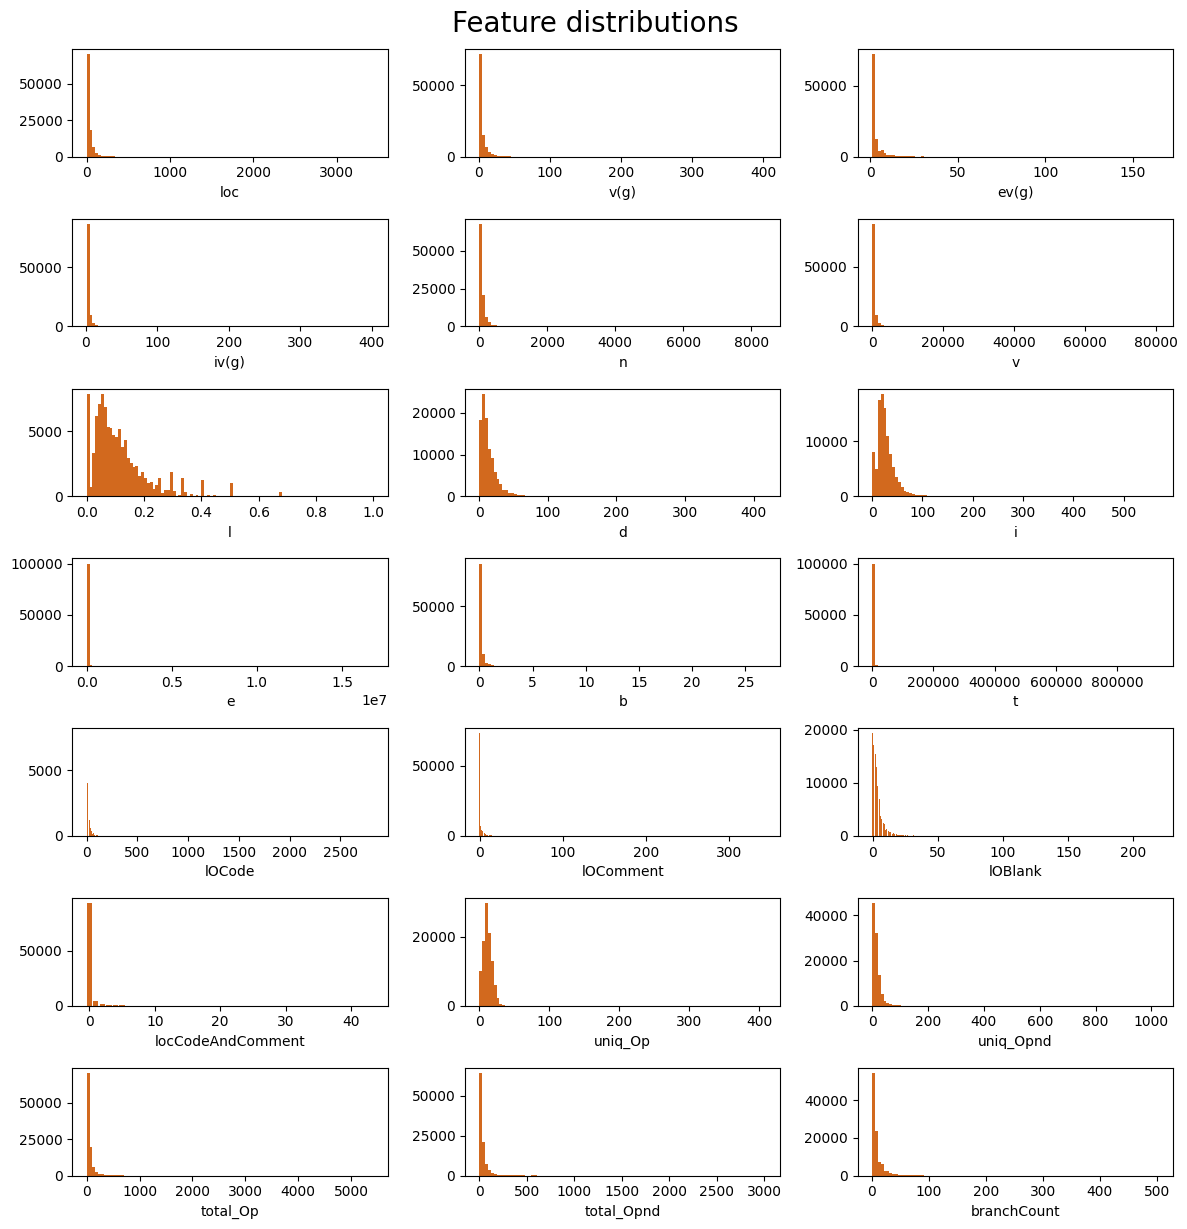

In [6]:
_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test.columns, axs.ravel()):
    if train[col].dtype == float:
        ax.hist(train[col], bins=100, color='chocolate')
    else: #int
        vc = train[col].value_counts()
        ax.bar(vc.index, vc, color='chocolate')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

**Insight:** 이런 종류의 분포에서는 파이프라인 앞에 FunctionTransformer(np.log1p)를 추가하여 데이터를 로그 변환함으로써 많은 모델이 이익을 얻을 수 있음.

KeyboardInterrupt: 

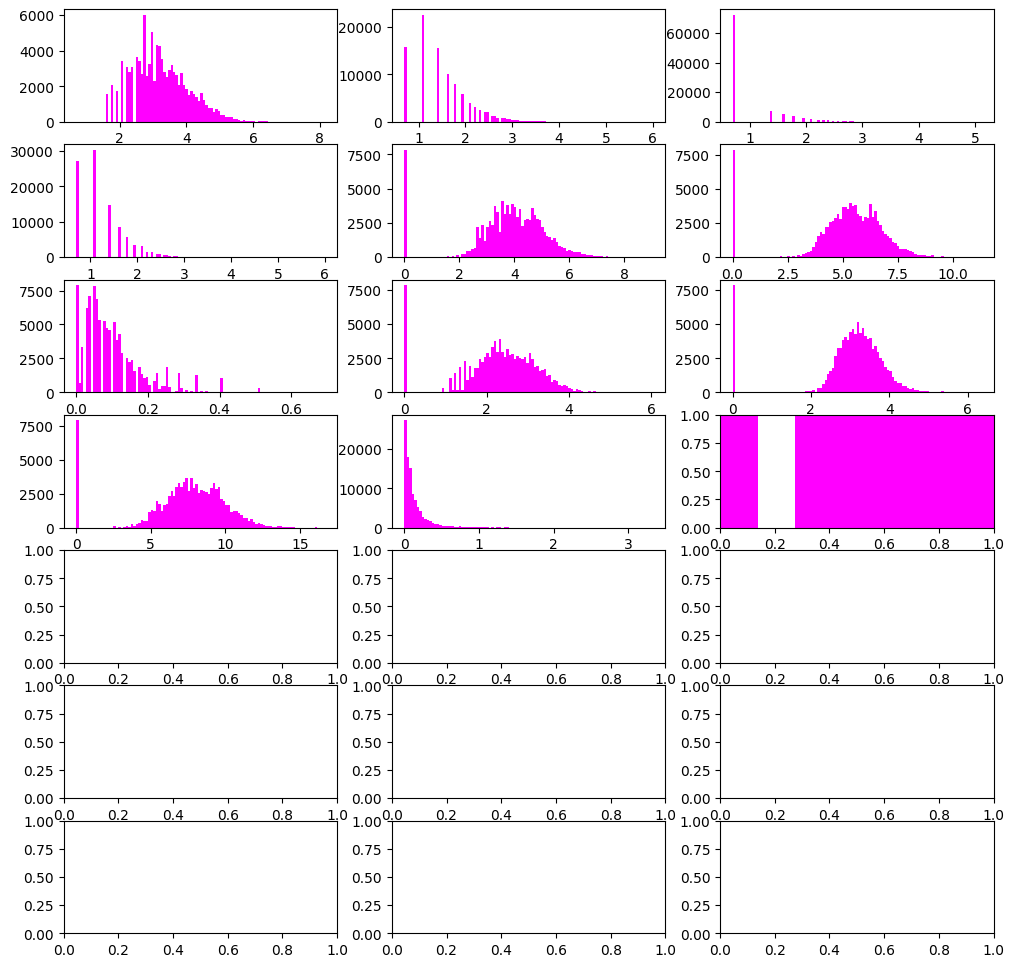

In [18]:
_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test.columns, axs.ravel()):
    ax.hist(np.log1p(train[col]), bins=100, color='magenta')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions after log transformation', y=1.02, fontsize=20)
plt.show()

# Cross-validation

- 모델을 StratifiedKFold로 교차 검증한다.
- 교차 검증 점수가 출력되며 전역 result_list에 추가된다.

In [20]:
def cross_val(model, label):
    """Cross-validate the model with a StratifiedKFold
    
    The cross-validation score is printed and added to the global result_list"""
    start_time = datetime.now()
    kf = StratifiedKFold(shuffle=True, random_state=1)
    oof = np.full(len(train), np.nan)
    auc_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.defects)):
        X_tr = train.iloc[idx_tr]
        X_va = train.iloc[idx_va]
        y_tr = X_tr.pop('defects')
        y_va = X_va.pop('defects')
        model.fit(X_tr, y_tr)
#         print(np.round(model[-1].coef_, 2), np.round(model[-1].intercept_, 2))
        try:
            y_va_pred = model.predict_proba(X_va)[:, 1]
        except AttributeError: # 'LinearSVC' object has no attribute 'predict_proba'
            y_va_pred = model.decision_function(X_va)
        oof[idx_va] = y_va_pred
        auc = roc_auc_score(y_va, y_va_pred)
        auc_list.append(auc)
    auc = np.array(auc_list).mean()
    execution_time = datetime.now() - start_time
    print(f"# AUC {auc:.5f}   time={str(execution_time)[-15:-7]}   {label}")
    result_list.append((auc, label, execution_time))
#     plt.figure(figsize=(6, 2))
#     plt.hist(oof, bins=200, density=True)
#     plt.show()
    return auc
    

In [21]:
def plot_score_list(label, parameter, xscale='linear'):
    """Show a scatterplot of the scores in the global variable score_list"""
    plt.figure(figsize=(6, 3))
    plt.scatter([p for p, s in score_list],
                [s for p, s in score_list])
    plt.xscale(xscale)
    plt.xlabel(f'{parameter}{" (log-scale)" if xscale == "log" else ""}')
    plt.ylabel('AUC score')
    plt.title(label)
    plt.show()

# A few models
## LinearSVC and LogisticRegression

Good to know:
- LinearSVC and LogisticRegression are usually used in a pipeline after a StandardScaler.
- Linear models are often improved if we add polynomial features. As the dataset has only 21 features, we can afford to add all products of two features by inserting a `PolynomialFeatures(include_bias=False)` into the pipeline before the StandardScaler. With this addition, the dataset is blown up to 252 features.
- The documentation says for both algorithms: Prefer dual=False when n_samples > n_features.
- Regularization is controlled by C (low C = high regularization).
- For logistic regression, `solver='newton-cholesky'` is the fastest solver for the given dataset.
- For our dataset, LogisticRegression gives good scores with `class_weight='balanced`. All predicted probabilities will be too high, but this doesn't hurt the auc score.

The plots show that the hyperparameter `C` does matter. You'll rarely get good results without tuning `C`.

In [22]:
# LinearSVC
score_list = []
for C in np.logspace(-4, -1, 4):
    auc = cross_val(make_pipeline(FunctionTransformer(np.log1p),
                                  PolynomialFeatures(2, include_bias=False),
                                  StandardScaler(),
                                  LinearSVC(dual=False, C=C)),
                    f'Poly-LinearSVC {C=:.2g}')
    score_list.append((C, auc))
plot_score_list('Poly-LinearSVC', 'C', 'log')

# AUC 0.78668   time=0:00:30   Poly-LinearSVC C=0.0001
# AUC 0.78826   time=0:00:55   Poly-LinearSVC C=0.001


# AUC 0.78917   time=0:00:14   Poly-LogisticRegression C=0.01
# AUC 0.78947   time=0:00:13   Poly-LogisticRegression C=0.024
# AUC 0.78964   time=0:00:13   Poly-LogisticRegression C=0.056
# AUC 0.78972   time=0:00:14   Poly-LogisticRegression C=0.13
# AUC 0.78970   time=0:00:12   Poly-LogisticRegression C=0.32
# AUC 0.78955   time=0:00:12   Poly-LogisticRegression C=0.75
# AUC 0.78941   time=0:00:13   Poly-LogisticRegression C=1.8
# AUC 0.78923   time=0:00:16   Poly-LogisticRegression C=4.2
# AUC 0.78908   time=0:00:13   Poly-LogisticRegression C=10


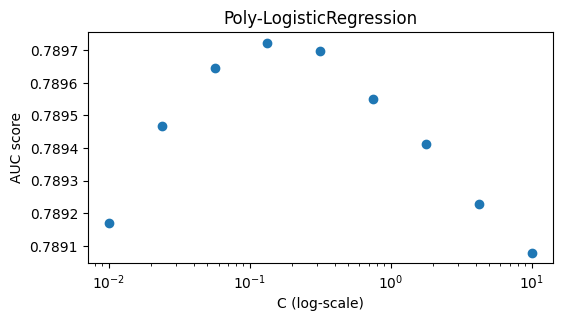

In [ ]:
# LogisticRegression
score_list = []
for C in np.logspace(-2, 1, 9):
    auc = cross_val(make_pipeline(FunctionTransformer(np.log1p),
                                  PolynomialFeatures(2, include_bias=False),
                                  StandardScaler(),
                                  LogisticRegression(dual=False, C=C,
                                                     class_weight='balanced',
                                                     max_iter=1500,
                                                     random_state=1,
                                                     solver='newton-cholesky')),
                    f'Poly-LogisticRegression {C=:.2g}')
    score_list.append((C, auc))
plot_score_list('Poly-LogisticRegression', 'C', 'log')


# Kernel approximation

**Kernel methods** are somewhat neglected on Kaggle, but they will play a role in this competition.

They have been developed based on two observations:
1. Linear machine learning models are limited because most machine learning tasks require a nonlinear solution.
2. Linear machine learning algorithms typically only apply linear operations in a vector space (vector addition, multiplication by a scalar, and scalar products) to the training and test data.

The math behind kernel methods takes some time to digest, but the main idea is that the data is mapped nonlinearly into a higher-dimensional vector space, and the linear classifier is applied to the higher-dimensional data. Because of the higher dimension, the linear classifier has more degrees of freedom to find a good decision surface. One can as well think of kernel methods as a form of automated feature engineering which generates nonlinear features for the linear classifier.

The drawback of kernel methods is their complexity: They work with a kernel matrix of size n_samples\*n_samples, and calculating a 100000\*100000 matrix for a 100000-row dataset takes too much time and memory. This is where **kernel approximation** enters the scene. Kernel approximation has almost the same benefits as the full kernel method, but at lower cost.

The following notebook cell cross-validates a linear classifier (logistic regression) with kernel approximation (Nyström approximation). Notice how the pipeline steps match the insight gained from EDA:
- We start with a log transformation because our EDA has shown the right-skewed nonnegative feature distributions.
- We then apply the Nyström approximation because we know that the dataset is too large to compute the full kernel matrix.

**TLDR:** The pipeline is the same as before, except that we have replaced `PolynomialFeatures` by `Nystroem`, and the score is substantially better.

In [ ]:
# Kernel approximation for logistic regression
score_list = []
n_components = 400
for C in np.logspace(-3, -2, 9):
    auc = cross_val(make_pipeline(FunctionTransformer(np.log1p),
                                  Nystroem(n_components=n_components, random_state=10), # gamma=1/21
                                  StandardScaler(),
                                  LogisticRegression(dual=False, C=C,
                                                     class_weight='balanced',
                                                     max_iter=1500,
                                                     random_state=1,
                                                     solver='newton-cholesky')),
                    f'Nyström-LogisticRegression {n_components=} {C=:.2g}')
    score_list.append((C, auc))
plot_score_list('Nyström LogisticRegression', 'C', 'log')


# AUC 0.79103   time=0:00:31   Nyström-LogisticRegression n_components=400 C=0.001
# AUC 0.79108   time=0:00:28   Nyström-LogisticRegression n_components=400 C=0.0013


KeyboardInterrupt: 

Further reading about the topic:
- [Kernel method](https://en.wikipedia.org/wiki/Kernel_method) on Wikipedia
- [Kernel approximation](https://scikit-learn.org/stable/modules/kernel_approximation.html) in the scikit-learn User Guide
- [Low-rank matrix approximations](https://en.wikipedia.org/wiki/Low-rank_matrix_approximations) on Wikipedia

## ExtraTreesClassifier

Good to know:
- ExtraTreesClassifier의 가장 중요한 하이퍼파라미터는 min_samples_leaf 이다.
  - 높은 min_samples_leaf: 추정기는 빠르지만 과소적합하다.
  - 낮은 min_samples_leaf: 추정기는 느리며 과대적합하다.
- max_features를 1.0으로 설정하면 일반적으로 기본값인 max_features='sqrt'보다 더 좋은 auc 점수를 얻지만, 훈련 과정을 느리게한다. 

# AUC 0.78647   time=0:04:20   ET min_samples_leaf=10
# AUC 0.78937   time=0:03:22   ET min_samples_leaf=20
# AUC 0.79123   time=0:02:14   ET min_samples_leaf=50
# AUC 0.79136   time=0:02:02   ET min_samples_leaf=100
# AUC 0.79116   time=0:01:46   ET min_samples_leaf=150


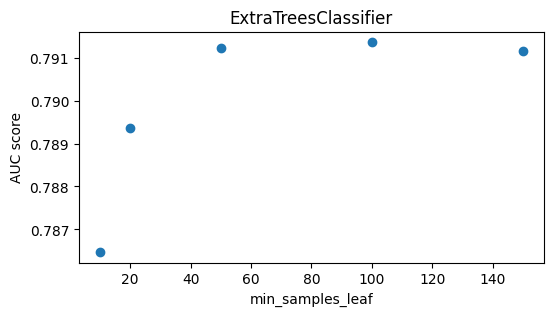

In [ ]:
# ExtraTreesClassifier
score_list = []
for min_samples_leaf in [10, 20, 50, 100, 150]:
    auc = cross_val(make_pipeline(FunctionTransformer(np.log1p),
                                  ExtraTreesClassifier(n_estimators=100,
                                         min_samples_leaf=min_samples_leaf,
                                         max_features=1.0,
                                         random_state=1)),
                    f"ET {min_samples_leaf=}")
    score_list.append((min_samples_leaf, auc))
plot_score_list('ExtraTreesClassifier', 'min_samples_leaf')


 ExtraTreesClassifier 점수가 min_samples_leaf 하이퍼파라미터에 어떻게 의존하는지 보여준다.
 100의 값이 최적인 것으로 보인다.

## RandomForestClassifier

Good to know:
- 랜덤 포레스트의 가장 중요한 하이퍼파라미터는 min_samples_leaf 이다.
 - 높은 min_samples_leaf: 추정기는 빠르지만 과소적합하다.
 - 낮은 min_samples_leaf: 추정기는 느리며 과대적합하다.
- max_features를 1.0으로 설정하면 일반적으로 기본값인 max_features='sqrt'보다 더 좋은 auc 점수를 얻지만, 훈련 과정을 느리게 한다.

In [ ]:
# RandomForestClassifier
score_list = []
for min_samples_leaf in [100, 150, 200, 250, 300]:
    auc = cross_val(RandomForestClassifier(n_estimators=100,
                                           min_samples_leaf=min_samples_leaf,
                                           max_features=1.0,
                                           random_state=1),
                    f"RF {min_samples_leaf=}")
    score_list.append((min_samples_leaf, auc))
plot_score_list('RandomForestClassifier', 'min_samples_leaf')

# AUC 0.78969   time=0:05:33   RF min_samples_leaf=50
# AUC 0.79057   time=0:04:50   RF min_samples_leaf=100
# AUC 0.79104   time=0:04:12   RF min_samples_leaf=200
# AUC 0.79074   time=0:03:43   RF min_samples_leaf=300
# AUC 0.79058   time=0:03:29   RF min_samples_leaf=400

그래프는 랜덤 포레스트 점수가 `min_samples_leaf`에 어떻게 의존하는지 보여준다. 150에서 200 사이의 값이 최적인 것으로 보인다.

## KNeighborsClassifier

Good to know:
- KNeighborsClassifier는 보통 StandardScaler 다음에 파이프라인에서 사용된다.
- 가장 중요한 하이퍼파라미터는 n_neighbors이다.


In [ ]:
# KNeighborsClassifier
score_list = []
for n_neighbors in range(200, 800, 100):
    auc = cross_val(make_pipeline(FunctionTransformer(np.log1p),
                                  StandardScaler(),
                                  KNeighborsClassifier(n_neighbors=n_neighbors,
                                                       weights='distance')),
                    f"KNN {n_neighbors=}")
    score_list.append((n_neighbors, auc))
plot_score_list('KNeighborsClassifier', 'n_neighbors')


The plot shows that the optimum of `n_neighbors` lies around 400. Large datasets (>100k samples in this competition) usually go together with a high `n_neighbors`.

## HistGradientBoostingClassifier

Good to know:
- 샘플 크기가 10,000보다 크면 HistGradientBoostingClassifier는 조기 종료를 위해 훈련 데이터의 10%를 내부 검증 세트로 사용한다. 이는 우리가 `max_iter`를 조정할 필요가 없다는 것을 의미한다.

In [ ]:
# HistGradientBoostingClassifier
auc = cross_val(HistGradientBoostingClassifier(random_state=1),
                f"HistGradientBoostingClassifier")


# AUC 0.79121   time=0:00:07   HistGradientBoostingClassifier


HistGradientBoostingClassifier는 하이퍼파라미터 튜닝 없이도 다른 모델들만큼 좋다. 하이퍼파라미터를 조정하면 더 나은 점수를 기대할 수 있다.

# Ensemble

우리는 세 가지 모델, `HistGradientBoostingClassifier`, `RandomForestClassifier` 및 kernel approximation를 사용한 logistic regression를 앙상블한다:

In [ ]:
ensemble = VotingClassifier(
    [('hgb', HistGradientBoostingClassifier(random_state=1)),
     ('rf', RandomForestClassifier(min_samples_leaf=200,
                                   max_features=1.0,
                                   random_state=1)),
     ('ny', make_pipeline(FunctionTransformer(np.log1p),
                                      Nystroem(n_components=400, random_state=1),
                                      StandardScaler(),
                                      LogisticRegression(dual=False, C=0.0032,
                                                         max_iter=1500,
                                                         random_state=1)))],
    voting='soft',
    weights=[0.5, 0.3, 0.2])
auc = cross_val(ensemble, 'Ensemble(HGB+RF+NY)')


# Final comparison

조정된 분류기의 장점을 쉽게 비교하기 위해, 다이어그램이 도움이 됨:

In [ ]:
result_df = pd.DataFrame(result_list, columns=['auc', 'label', 'time'])
result_df['time'] = result_df.time.dt.seconds
result_df['model'] = result_df.label.str.split(expand=True).iloc[:,0]
result_df = result_df.sort_values('auc', ascending=False)
# with pd.option_context("display.precision", 5): display(result_df)
result_df = result_df.drop_duplicates('model', keep='first')
plt.figure(figsize=(6, len(result_df) * 0.4))

def color_map(row):
    if row['label'].startswith('Ensemble'): return 'green'
    if row['auc'] > 0.79050: return 'lightgreen'
    return 'yellow'

colors = result_df.apply(color_map, axis=1)
bars = plt.barh(np.arange(len(result_df)), result_df.auc, color=colors)
plt.gca().bar_label(bars, fmt='%.5f')
plt.yticks(np.arange(len(result_df)), result_df.label)
plt.xlim(0.785, 0.795)
plt.xticks([0.785, 0.79, 0.795])
plt.gca().invert_yaxis()
plt.xlabel('AUC score (higher is better)')
plt.show()

**Insight:**
- The ensemble (dark green) obviously wins.
- HistGradientBoosting and ExtraTrees have the best scores of the single models. Other gradient-boosting methods (LightGBM, XGBoost, Catboost) will have similarly good scores. In all cases, you'll need to tune the hyperparameters.
- Random forest and Nyström logistic regression belong to the top group as well. All models with a light green bar in the chart must be included in the final ensemble.
- Logistic regression and LinearSVC have lower scores. This means that the class boundary of the given dataset is nonlinear (and not even quadratic). If you want to get a good score with a linear model, you need to engineer features which account for the nonlinearity of the data.
- KNeighborsClassifier ends up last.

# AUC score explained

(Skip this section if you already know what the AUC score is.)

Many binary classification competitions on Kaggle are evaluated on *area under the ROC curve*.

Classification models usually predict a probability (`predict_proba`) or a decision function value for every sample. To convert these numbers into class predictions (`predict`), the predicted probability is compared to a threshold. If the probability is above the threshold, the model predicts the positive class; if the probability is below the threshold, the model predicts the negative class.

By varying the threshold, we can choose different trade-offs between false positives and false negatives. The receiver operating curve plots the true positive rate against the false positive rate while varying the threshold. 


In [ ]:
def plot_roc_curve(model):
    """Plot the ROC curve for the first fold"""
    kf = StratifiedKFold(shuffle=True, random_state=1)
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.defects)):
        X_tr = train.iloc[idx_tr]
        X_va = train.iloc[idx_va]
        y_tr = X_tr.pop('defects')
        y_va = X_va.pop('defects')
        model.fit(X_tr, y_tr)
        y_va_pred = model.predict_proba(X_va)[:, 1]
        auc = roc_auc_score(y_va, y_va_pred)

        plt.figure(figsize=(4, 4))
        fpr, tpr, _ = roc_curve(y_va, y_va_pred)
        plt.plot(fpr, tpr, color='r', lw=2)
        plt.fill_between(fpr, tpr, color='r', alpha=0.2)
        plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
        plt.gca().set_aspect('equal')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Receiver operating characteristic\nArea under the curve = {auc:.5f}")
        plt.show()
        break

plot_roc_curve(ensemble)

- The lower left corner of the diagram corresponds to a very high threshold so that the model always predicts the negative class. There are zero positive predictions, i.e. 0 true positives and 0 false positives.
- The upper right corner of the diagram corresponds to a very low threshold so that the model always predicts the positive class. The model predicts all positive samples correctly (recall = true positive rate = 1.0), and it predicts all negative samples as false positives (false positive rate = 1.0).

The AUC score is the area under the red curve. It usually is between 0.5 (area of the lower triangle) and 1.0 (area of the square).
- With a perfect classification model, the curve would pass through the upper left corner (recall = 1.0 and no false positives) for an area under the curve of 1.0.
- With a dummy classification model which makes random predictions or always predicts the same class, the curve follows the diagonal of the square for an area under the curve of 0.5.


# Submission

In [ ]:
%%time
ensemble.fit(train.iloc[:, :-1], train.defects)
y_pred = ensemble.predict_proba(test)[:, 1]
submission = pd.Series(y_pred, index=test.index, name='defects')
submission.to_csv('submission.csv')
!head submission.csv